# Multi-level Quantum Circuit parti

Full workflow for parti quantum circuits using a multi-level Fiduccia-Mattheyses algorithm.

The workflow begins by transpiling a quantum circuit into the controlled phase and general unitary gate set. This is done using the qiskit transpile function.

The circuit is then converted into a GCP hypergraph, with a node for each qubit at each time-step of the circuit, edges connecting successor nodes for each qubit, and hyperedges connecting nodes involved in distributable gates.

In [3]:
from disqco.circuits.cp_fraction import cp_fraction
from disqco.graphs.GCP_hypergraph import QuantumCircuitHyperGraph
from qiskit import transpile
from disqco.parti.FM.FM_methods import set_initial_partitions, get_all_configs, get_all_costs
from qiskit.circuit.library import QFT, QuantumVolume, EfficientSU2
from disqco.circuits.QAOA import QAOA_random
import numpy as np
import time
from disqco.graphs.quantum_network import QuantumNetwork

num_qubits = 32
num_partitions = 4
qpu_size = int(num_qubits / num_partitions) + 1
qpu_sizes = [qpu_size] * num_partitions

network = QuantumNetwork(qpu_sizes)


circuit = cp_fraction(  num_qubits=num_qubits,
                        depth=num_qubits,
                        fraction= 0.5)

circuit = transpile(circuit, basis_gates = ['cp', 'u'])

depth = circuit.depth()

print(depth*num_qubits)

graph = QuantumCircuitHyperGraph(circuit, group_gates = True, anti_diag = True)
assignment = set_initial_partitions(network, num_qubits, depth, num_partitions)

start = time.time()
configs = get_all_configs(num_partitions)
costs = get_all_costs(configs)
stop = time.time()

print(assignment)

1024
{(0, 0): 3, (1, 0): 3, (2, 0): 3, (3, 0): 3, (4, 0): 3, (5, 0): 3, (6, 0): 3, (7, 0): 3, (8, 0): 3, (9, 0): 2, (10, 0): 2, (11, 0): 2, (12, 0): 2, (13, 0): 2, (14, 0): 2, (15, 0): 2, (16, 0): 2, (17, 0): 2, (18, 0): 1, (19, 0): 1, (20, 0): 1, (21, 0): 1, (22, 0): 1, (23, 0): 1, (24, 0): 1, (25, 0): 1, (26, 0): 1, (27, 0): 0, (28, 0): 0, (29, 0): 0, (30, 0): 0, (31, 0): 0, (0, 1): 3, (1, 1): 3, (2, 1): 3, (3, 1): 3, (4, 1): 3, (5, 1): 3, (6, 1): 3, (7, 1): 3, (8, 1): 3, (9, 1): 2, (10, 1): 2, (11, 1): 2, (12, 1): 2, (13, 1): 2, (14, 1): 2, (15, 1): 2, (16, 1): 2, (17, 1): 2, (18, 1): 1, (19, 1): 1, (20, 1): 1, (21, 1): 1, (22, 1): 1, (23, 1): 1, (24, 1): 1, (25, 1): 1, (26, 1): 1, (27, 1): 0, (28, 1): 0, (29, 1): 0, (30, 1): 0, (31, 1): 0, (0, 2): 3, (1, 2): 3, (2, 2): 3, (3, 2): 3, (4, 2): 3, (5, 2): 3, (6, 2): 3, (7, 2): 3, (8, 2): 3, (9, 2): 2, (10, 2): 2, (11, 2): 2, (12, 2): 2, (13, 2): 2, (14, 2): 2, (15, 2): 2, (16, 2): 2, (17, 2): 2, (18, 2): 1, (19, 2): 1, (20, 2): 1, (21,

In [2]:
from disqco.parti.FM.FM_main import run_FM

final_cost, final_assignment, cost_list = run_FM(
    graph,
    assignment,
    qpu_sizes,
    num_partitions,
    limit=num_qubits*graph.depth/8,
    max_gain=4,
    passes=100,
    stochastic=True,
    active_nodes=graph.nodes,
    log = False,
    add_initial = False,
    costs = None
)

print("cost list", cost_list)


IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

In [ ]:
from src.multilevel_FM import *

assignment_list, cost_list, time_list = MLFM_window(graph,
                num_levels=8,
                initial_assignment=assignment,  
                qpu_info= qpu_info, 
                limit = None, 
                pass_list= None, 
                stochastic=True, 
                lock_nodes=True,
                log = False,
                add_initial = False,
                costs = None)

print(min(cost_list))

start = time.time()
final_cost = optimise_detached_hyperedges(graph, assignment_list[np.argmin(cost_list)], num_partitions, costs)
print("Extra time:", time.time() - start)

print(final_cost)

In [ ]:
assignment_list, cost_list, time_list = MLFM_blocks(graph,
                num_blocks=8,
                initial_assignment=assignment,  
                qpu_info= qpu_info, 
                limit = None, 
                pass_list= None, 
                stochastic=True, 
                lock_nodes=True,
                log = False,
                add_initial = False,
                costs = None,
                full = True)

print(min(cost_list))

final_cost = optimise_detached_hyperedges(graph, assignment_list[np.argmin(cost_list)], num_partitions, costs)
print(final_cost)

In [ ]:
from disqco.parti.FM.multilevel_FM import MLFM_recursive
from disqco.parti.FM.FM_methods import calculate_full_cost

import time

passes = [5] * 12

assignment_list, cost_list, time_list = MLFM_recursive(graph,
                                        assignment,  
                                        qpu_info, 
                                        limit = num_qubits, 
                                        pass_list = passes, 
                                        stochastic = False, 
                                        lock_nodes = False,
                                        log = True,
                                        add_initial = False,
                                        costs = None,
                                        level_limit = None)

print(min(cost_list))

assignment = assignment_list[np.argmin(cost_list)]

# for i, ass in enumerate(assignment_list):

#     print('Cost:', calculate_full_cost(graph, ass, num_partitions, costs))
#     print('Cost from list:', cost_list[i])

# start = time.time()
# final_cost = optimise_detached_hyperedges(graph, assignment, num_partitions, costs)
# end = time.time()
# print("Extra time:", end - start)
# print(final_cost)

Initial cost: 31
All passes complete.
Final cost: 31
Best cost at level 0: 31
Initial cost: 31
All passes complete.
Final cost: 31
Best cost at level 1: 31
Initial cost: 31
All passes complete.
Final cost: 31
Best cost at level 2: 31
Initial cost: 31
All passes complete.
Final cost: 31
Best cost at level 3: 31
Initial cost: 31
All passes complete.
Final cost: 31
Best cost at level 4: 31
Initial cost: 31
All passes complete.
Final cost: 31
Best cost at level 5: 31
Initial cost: 31
All passes complete.
Final cost: 31
Best cost at level 6: 31
Initial cost: 31
All passes complete.
Final cost: 31
Best cost at level 7: 31
31


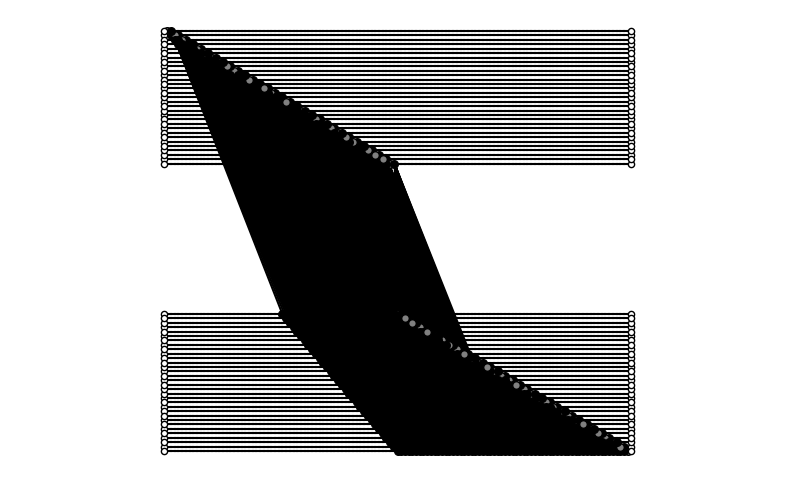

In [ ]:
from disqco.drawing.tikz_drawing import *
from disqco.drawing.mpl_drawing import *
assignment = assignment_list[np.argmin(cost_list)]

mpl_fig = hypergraph_to_matplotlib(
    graph, 
    num_qubits,
    assignment,
    qpu_info,
    depth,
    xscale=10/depth,
    yscale=6/num_qubits,
)

In [ ]:
num_qubits = 48
num_partitions = 6
qpu_size = int(num_qubits / num_partitions) + 1
qpu_info = [qpu_size] * num_partitions


circuit = cp_fraction(  num_qubits=num_qubits,
                        depth=num_qubits,
                        fraction= 0.9 )

# circuit = QFT(num_qubits, do_swaps=False)

# circuit = QuantumVolume(num_qubits, depth=num_qubits)

# circuit = QAOA_random(num_qubits, prob = 0.9, reps = 1)

# ansatz = EfficientSU2(num_qubits, entanglement='full', reps=1)

# param_values = np.random.rand(len(ansatz.parameters))
# param_dict = dict(zip(ansatz.parameters, param_values))
# circuit = ansatz.assign_parameters(param_dict)
cost_list_diag = []
cost_list_anti = []

for i in range(20):
    print("Iteration", i)
    circuit = transpile(circuit, basis_gates = ['cp', 'u'])

    depth = circuit.depth()

    graph = QuantumCircuitHyperGraph(circuit, group_gates=True)
    assignment = set_initial_partitions(qpu_info, num_qubits, depth, num_partitions, reduced = True)

    assignment_list, cost_list, time_list = MLFM_recursive(graph,
                                        assignment,  
                                        qpu_info, 
                                        limit = None, 
                                        pass_list= None, 
                                        stochastic=True, 
                                        lock_nodes=False,
                                        log = False,
                                        add_initial = False,
                                        costs = None)
    
    cost_list_diag.append(min(cost_list))

    graph = QuantumCircuitHyperGraph(num_qubits=num_qubits, depth=depth)
    graph.map_circuit_to_hypergraph(circuit, group_gates=True, anti_diag = True)
    assignment = set_initial_partitions(qpu_info, num_qubits, depth, num_partitions, reduced = True)

    assignment_list, cost_list, time_list = MLFM_recursive(graph,
                                        assignment,  
                                        qpu_info, 
                                        limit = None, 
                                        pass_list= None, 
                                        stochastic=True, 
                                        lock_nodes=False,
                                        log = False,
                                        add_initial = False,
                                        costs = None)

    cost_list_anti.append(min(cost_list))

    



Iteration 0


TypeError: QuantumCircuitHyperGraph.__init__() got an unexpected keyword argument 'num_qubits'

In [ ]:
print(np.mean(cost_list_diag))
print(np.mean(cost_list_anti))

284.8
282.4


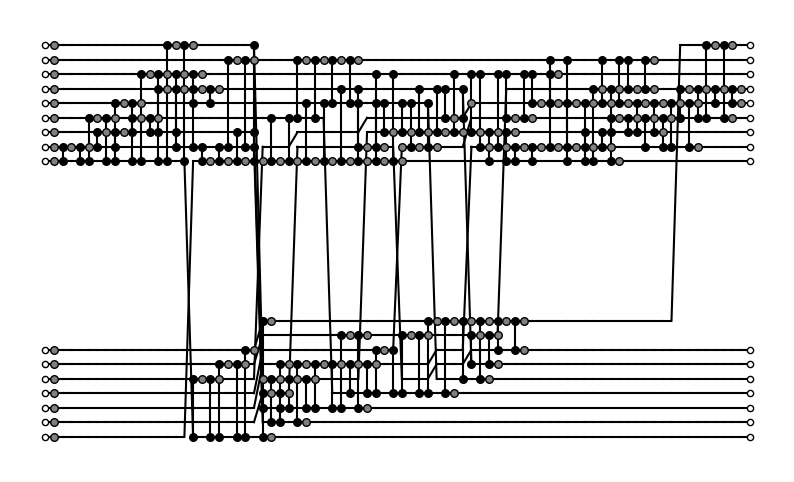

In [ ]:
from src.tikz_drawing import *
from src.mpl_drawing import *
assignment = assignment_list[np.argmin(cost_list)]

mpl_fig = hypergraph_to_matplotlib(
    graph, 
    num_qubits,
    assignment,
    qpu_info,
    depth,
    sum(qpu_info),
    xscale=15.0,
    yscale=25.0,
    figsize=(10, 6),
    save=False,
    path=None,
    ax=None
)